In [1]:
%matplotlib inline

# Evaluating robustness of Multivariate Hyperbolic Secant Mixture model(HSMM)
+ This notebook compares HSMM with Gaussian Mixture Model (GMM) in terms of counting correct labeling.

## Method:
+ As the cluster distribution, the following distributions are used, and compare clustering performance:


1. Gaussian distribution
1. Hyperbolic secant distribution
1. Laplace distribution
1. Gumbel distribution
1. Student distribution
1. Cauchy distribution
1. Gamma distribution
1. Skew Normal distribution
1. Parato distribution

### Suplementary material: Local Variational Approximation algorithm for HSMM
+ Model:
    + $p(x|w) = \sum_{k=1}^K a_k \prod_{j = 1}^M \frac{\sqrt{s_{kj}}}{2\pi} \frac{1}{\cosh(\frac{s_{kj}}{2}(x_j - b_{kj}))}$
    + $x, b_k \in \mathbb{R}^M, s_k \in \mathbb{R}_+^M$
+ Prior distribution:
    + $\varphi(w) = Dir(a|\{ \alpha_k \}_{k=1}^K) \prod_{k=1}^K N(b_k|0, (s_k \beta_k)^{-1} ) Gam(s_k|\gamma_k, \delta_k)$
+ Algorithm
   1. Initializing the following values:
       + $g_{ikj}(\eta), v_{ikj}(\eta), h_{ik}(\xi), u_{ik}(\xi)$
   2. Update the following values
       + $\hat{\alpha}_k = \alpha_k + \sum_{i=1}^n u_{ik}(\xi)$
       + $\hat{\beta}_{kj} = \beta_k + \sum_{i=1}^n -2v_{ikj}(\eta)$
       + $\hat{m}_{kj} = \frac{1}{\hat{\beta}_k} \sum_{i=1}^n -2v_{ik}(\eta)x_i$
       + $\hat{\gamma}_{kj} = \gamma_k + \frac{1}{2}\sum_{i=1}^n u_{ik}(\xi)$
       + $\hat{\delta}_{kj} = \delta_k + \sum_{i=1}^n -v_{ikj}(\eta)x_{ij}^2 - \frac{\hat{\beta}_{kj}}{2}\hat{m}_{kj}^2$
   3. Update the following values
       + $g_{ikj}(\eta) = \frac{\hat{\gamma}_{kj}}{\hat{\delta}_{kj}} (x_{ij} - \hat{m}_{kj})^2 + \frac{1}{\hat{\beta}_{kj}}$
       + $v_{ikj}(\eta) = -u_{ik}(\xi)\frac{ \tanh(\sqrt{g_{ikj}(\eta)}/2) }{4\sqrt{g_{ikj}(\eta)}}$
   4. Update the following values
       + $h_{ik}(\xi) = \psi(\hat{\alpha}_k) - \psi(\sum_{l=1}^K \hat{\alpha}_l) + \frac{1}{2} \sum_{j=1}^M (\psi(\hat{\gamma}_{kj}) - \log(\hat{\delta}_{kj})) - \sum_{j=1}^M \log(\cosh(\sqrt{g_{ikj}(\eta)}/2)) $
       + $u_{ik}(\xi) = \frac{ \exp(h_{ik}(\xi)) }{ \sum_{l=1}^K \exp(h_{il}(\xi)) }$
       + where,$\psi(x) = \frac{d}{dx}\log \Gamma(x)$
   5. Return back to 2.
   
+ Evaluation function $\overline{F}_{\xi, \eta}(x^n)$:
    + $\overline{F}_{\xi, \eta}(x^n) = - \phi(h(\xi)) - \psi(g(\eta)) + u(\xi) \cdot h(\xi) + v(\eta) \cdot g(\eta) $  
        $+ nM \log 2 \pi + \log \Gamma(\sum_{l = 1}^K \hat{\alpha}_l) - \log \Gamma({\sum_{l = 1}^K\alpha}_l) + \sum_{k=1}^K \log \frac{\Gamma(\alpha_k)}{\Gamma(\hat{\alpha}_k)}$  
        $+ \sum_{k=1}^K \sum_{j=1}^M \bigl\{ \frac{1}{2} \log \frac{\hat{\beta}_{kj}}{\beta_{kj}} + \hat{\gamma}_{kj} \log \hat{\delta}_{kj} - \gamma_{kj} \log \delta_{kj} - \log \Gamma(\hat{\gamma}_{kj}) + \log \Gamma(\gamma_{kj}) \bigr\}$

In [2]:
from IPython.core.display import display, Markdown, Latex
import math
import numpy as np
from scipy.special import gammaln, psi
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, t, cauchy, laplace, gumbel_r, gamma, skewnorm, pareto, multivariate_normal
from typing import Callable

## Used funtions

In [3]:
def printmd(x):
    display(Markdown(x))

In [4]:
def random_hsm(n, loc = 0, scale = 1):
    """
    Generate data following hyperbolic secant distribution.
    Let $Y \sim standard_cauchy(x)$,  
    random variable $X = \frac{2}{\sqrt{s}}\sinh^{-1}(Y) + b$ follows to  
    $X \sim p(x) = \frac{\sqrt{s}}{2\pi}\frac{1}{\cosh(s(x-b)/2)}$.
    """
    Y = np.random.standard_cauchy(size=n)
    X = 2/np.sqrt(scale)*np.arcsinh(Y) + loc    
    return X

In [5]:
def logpdf_hypsecant(x:np.ndarray, mean:np.ndarray, precision:np.ndarray):
    """
    Calculate \log p(x|w) = \sum_{j=1}^M \log(\frac{\sqrt{s_j}}{2\pi} 1/cosh(\sqrt{s_j}/2(x_j - b_j)))
    Input:
     + x: n*M
     + mean: M
     + precision :M
    Output:
     + n*M
    """
    (n, M) = x.shape
    expand_precision = np.repeat(precision, n).reshape(M,n).T
    y = np.sqrt(expand_precision)*(x - np.repeat(mean, n).reshape(M,n).T)/2
    return(np.log(expand_precision)/2 - np.log(2*np.pi) - logcosh(y)).sum(axis = 1)

def logpdf_multivariate_normal(x:np.ndarray, mean:np.ndarray, precision:np.ndarray):
    """
    Calculate \log p(x|w) = \sum_{j=1}^M \log(\frac{\sqrt{s_j}}{2\pi} 1/cosh(\sqrt{s_j}/2(x_j - b_j)))
    Input:
     + x: n*M
     + mean: M
     + precision :M
    Output:
     + n*M
    """
    (n, M) = x.shape
    expand_precision = np.repeat(precision, n).reshape(M,n).T
    y = expand_precision*(x - np.repeat(mean,n).reshape(M,n).T)**2/2
    return(np.log(expand_precision)/2 - np.log(2*np.pi)/2 - y).sum(axis = 1)
    pass

In [6]:
def logcosh(x:np.ndarray):
    ret_val = -x + np.log((1 + np.exp(2*x))/2)
    (row, col) = np.where(x > 0)
    ret_val[row, col] = x[row, col] + np.log((1 + np.exp(-2*x[row,col]))/2)
    return ret_val

# def logpdf_multivariate_normal(x:np.ndarray, mean:np.ndarray, precision:np.ndarray):
#     return multivariate_normal.logpdf(x, mean=mean, cov=np.diag(1/precision))

# def logpdf_hypsecant(x:np.ndarray, mean:np.ndarray, precision:np.ndarray):
#     return hypsecant.logpdf(x, mean, precision).sum(axis=1)

def logpdf_mixture_dist(x:np.ndarray, param:dict, component_log_dist:Callable[[np.ndarray, np.ndarray, np.ndarray], np.ndarray]):
    n = x.shape[0]
    K = len(param["ratio"])
    loglik = np.zeros((n,K))
    for k in range(K):
        loglik[:,k] = np.log(param["ratio"][k]) + component_log_dist(test_x, param["mean"][k,:],  param["precision"][k,:])
    max_loglik = loglik.max(axis = 1)
    norm_loglik = loglik - np.repeat(max_loglik,K).reshape(n,K)
    return (np.log(np.exp(norm_loglik).sum(axis = 1)) + max_loglik)

In [7]:
def fit_lva_gmm(train_X:np.ndarray, K:int,
                 pri_alpha = 0.1, pri_beta = 0.001, pri_gamma = 2, pri_delta = 2,
                 iteration = 1000, restart_num:int = 5, learning_seeds:list = None):
    """
    LVA for GMM.
    This is same with Variational Bayes inference for GMM.
    Since the algorithm fails to local minima, the best estimator are chosen in several initial values.
    
    + Input:
        + train_X: input data
        + pri_alpha: hyperparameter for prior distribution of symmetric Dirichlet distribution.
        + pri_beta: hyperparameter for prior distribution of Normal distribution for inverse variance.
        + pri_gamma: hyperparameter for prior distribution of Gamma distribution for shape parameter.
        + pri_delta: hyperparameter for prior distribution of Gamma distribution for rate parameter.
        + iteration: Number of iteration.
        + restart_num: Number of restart of inital values.
        + learning_seeds: Seeds for initial values.
        
    + Output:
        + Dictionary of the best estimated result:
            1. alpha: parameter for posterior distribution of Dirichlet distribution.
            2. mu: parameter for posterior distribution of Normal distribution for mean parameter.
            3. beta: parameter for posterior distribution of Normal distribution for inverse variance parameter.
            4. gamma: parameter for posterior distribution of Gamma distribution for shape parameter.
            5. delta: parameter for posterior distribution of Gamma distribution for rate parameter.
            6. h_xi: Value of E_w[log p(x_i, z_i = k|w)], where z_i is latent variable. This parameters form posterior latent distribution.
            7. u_xi: Value of p(z_i = k). This parameters represent posterior probability of latent variable
            8. energy: Value of the best evaluation function.
            9. seed: Value of the best learning seed.
    """
    
    (n, M) = train_X.shape
    ### Setting for static variable in the algorithm.
    expand_x = np.repeat(train_X, K).reshape(n, M, K).transpose((0, 2, 1)) ### n * K * M data with the same matrix among 2nd dimension

    min_energy = np.inf
    result = dict()
    
    for restart in range(restart_num):
        ### Set learning seed if learning_seeds is specified.
        if learning_seeds is not None and len(learning_seeds) >= restart:
            np.random.seed(learning_seeds[restart])

        energy = np.zeros(iteration)
        ### Setting for initial value
        est_u_xi = np.random.dirichlet(alpha = np.ones(K), size=n)
    
        ### Start learning.
        for ite in range(iteration):
            ### Update posterior distribution of parameter.
            est_alpha = pri_alpha + est_u_xi.sum(axis = 0)
            est_beta = np.repeat(pri_beta + est_u_xi.sum(axis = 0), M).reshape(K,M)
            est_m = est_u_xi.T @ train_X / est_beta
            est_gamma = np.repeat(pri_gamma + est_u_xi.sum(axis = 0)/2, M).reshape(K,M)
            est_delta = pri_delta + est_u_xi.T @ (train_X**2) /2 - est_beta / 2 * est_m**2
            
            ### Update posterior distribution of latent variable
            est_g_eta = np.repeat(est_gamma / est_delta, n).reshape(K,M,n).transpose((2,0,1)) * (expand_x - np.repeat(est_m,n).reshape(K,M,n).transpose((2,0,1)))**2 + 1/np.repeat(est_beta, n).reshape(K,M,n).transpose((2,0,1))
            est_h_xi = -M/2*np.log(2*np.pi) + np.repeat(psi(est_alpha) - psi(est_alpha.sum()) + (psi(est_gamma) - np.log(est_delta)).sum(axis = 1)/2, n).reshape(K,n).T - est_g_eta.sum(axis = 2)/2
            max_h_xi = est_h_xi.max(axis = 1)
            norm_h_xi = est_h_xi - np.repeat(max_h_xi,K).reshape(n,K)
            est_u_xi = np.exp(norm_h_xi) / np.repeat(np.exp(norm_h_xi).sum(axis = 1), K).reshape(n,K)

            ### Calculate evaluation function
            energy[ite] = - (np.log(np.exp(norm_h_xi).sum(axis = 1)) + max_h_xi).sum() + (est_u_xi * est_h_xi).sum()
            energy[ite] += gammaln(est_alpha.sum()) - gammaln(K*pri_alpha) + (-gammaln(est_alpha) + gammaln(pri_alpha)).sum()
            energy[ite] += (np.log(est_beta/pri_beta)/2 + est_gamma * np.log(est_delta) - pri_gamma * np.log(pri_delta) - gammaln(est_gamma) + gammaln(pri_gamma)).sum()
        
        print(energy[-1])        
        if energy[-1] < min_energy:
            min_energy = energy[-1]
            result["ratio"] = est_alpha / est_alpha.sum()
            result["mean"] = est_m
            result["precision"] = est_gamma / est_delta
            result["alpha"] = est_alpha
            result["mu"] = est_m
            result["beta"] = est_beta
            result["gamma"] = est_gamma
            result["delta"] = est_delta
            result["h_xi"] = est_h_xi
            result["u_xi"] = est_u_xi
            result["energy"] = energy
            if learning_seeds is not None and len(learning_seeds) >= restart:
                result["seed"] = learning_seeds[restart]
    return result

In [8]:
def fit_lva_hsmm(train_X:np.ndarray, K:int,
                 pri_alpha = 0.1, pri_beta = 0.001, pri_gamma = 2, pri_delta = 2,
                 iteration = 1000, restart_num:int = 5, learning_seeds:list = None):
    """
    LVA for HSMM.
    The algorithm is described in the above cell.
    Since the algorithm fails to local minima, the best estimator are chosen in several initial values.
    
    + Input:
        + train_X: input data
        + pri_alpha: hyperparameter for prior distribution of symmetric Dirichlet distribution.
        + pri_beta: hyperparameter for prior distribution of Normal distribution for inverse variance.
        + pri_gamma: hyperparameter for prior distribution of Gamma distribution for shape parameter.
        + pri_delta: hyperparameter for prior distribution of Gamma distribution for rate parameter.
        + iteration: Number of iteration.
        + restart_num: Number of restart of inital values.
        + learning_seeds: Seeds for initial values.
        
    + Output:
        + Dictionary of the best estimated result:
            1. alpha: parameter for posterior distribution of Dirichlet distribution.
            2. mu: parameter for posterior distribution of Normal distribution for mean parameter.
            3. beta: parameter for posterior distribution of Normal distribution for inverse variance parameter.
            4. gamma: parameter for posterior distribution of Gamma distribution for shape parameter.
            5. delta: parameter for posterior distribution of Gamma distribution for rate parameter.
            6. h_xi: Value of E_w[log p(x_i, z_i = k|w)], where z_i is latent variable. This parameters form posterior latent distribution.
            7. u_xi: Value of p(z_i = k). This parameters represent posterior probability of latent variable.
            8. g_eta: Value of auxiliary variable, which represents g(\eta) in the algorithm.
            9. v_eta: Value of auxiliary variable, which represents v(\eta) in the algorithm.
            10. energy: Value of the best evaluation function.
            11. seed: Value of the best learning seed.
    """    
    
    (n, M) = train_X.shape
    ### Setting for static variable in the algorithm.
    expand_x = np.repeat(train_X, K).reshape(n, M, K).transpose((0, 2, 1)) ### n * K * M data with the same matrix among 2nd dimension

    min_energy = np.inf
    result = dict()
    
    for restart in range(restart_num):
        ### Set learning seed if learning_seeds is specified.
        if learning_seeds is not None and len(learning_seeds) >= restart:
            np.random.seed(learning_seeds[restart])

        energy = np.zeros(iteration)
        ### Setting for initial value
        est_u_xi = np.random.dirichlet(alpha = np.ones(K), size=n)

        est_g_eta = np.abs(np.random.normal(size=(n,K,M)))
        est_v_eta = - np.repeat(est_u_xi, M).reshape(n, K, M) * np.tanh(np.sqrt(est_g_eta)/2)/(4*np.sqrt(est_g_eta))

        ### Start learning.
        for ite in range(iteration):
            ### Update posterior distribution of parameter
            est_alpha = pri_alpha + est_u_xi.sum(axis = 0)
            est_beta = pri_beta + (-2*est_v_eta.sum(axis = 0))
            est_m = -2 * (expand_x * est_v_eta).sum(axis = 0) / est_beta
            est_gamma = np.repeat(pri_gamma + est_u_xi.sum(axis = 0)/2, M).reshape(K,M)
            est_delta = pri_delta - (expand_x**2 * est_v_eta).sum(axis = 0) - est_beta / 2 * est_m**2
            
            ### Update auxiliary variables
            est_g_eta = np.repeat(est_gamma / est_delta, n).reshape(K,M,n).transpose((2,0,1)) * (expand_x - np.repeat(est_m,n).reshape(K,M,n).transpose((2,0,1)))**2 + 1/np.repeat(est_beta, n).reshape(K,M,n).transpose((2,0,1))
            est_v_eta = - np.repeat(est_u_xi, M).reshape(n, K, M) * np.tanh(np.sqrt(est_g_eta)/2)/(4*np.sqrt(est_g_eta))

            ### Update posterior distribution of latent variable
            sqrt_g_eta = np.sqrt(est_g_eta)
            est_h_xi = np.repeat(psi(est_alpha) - psi(est_alpha.sum()) + (psi(est_gamma) - np.log(est_delta)).sum(axis = 1)/2, n).reshape(K,n).T - (sqrt_g_eta/2 +  np.log( (1 + np.exp(-2*sqrt_g_eta/2 ))/2)).sum(axis = 2)
            max_h_xi = est_h_xi.max(axis = 1)
            norm_h_xi = est_h_xi - np.repeat(max_h_xi,K).reshape(n,K)
            est_u_xi = np.exp(norm_h_xi) / np.repeat(np.exp(norm_h_xi).sum(axis = 1), K).reshape(n,K)

            ### Calculate evaluation function
            energy[ite] = (np.repeat(est_u_xi, M).reshape(n, K, M) * (sqrt_g_eta/2 +  np.log( (1 + np.exp(-2*sqrt_g_eta/2 ))/2)) ).sum() - (np.log(np.exp(norm_h_xi).sum(axis = 1)) + max_h_xi).sum() + (est_u_xi * est_h_xi).sum() + (est_v_eta * est_g_eta).sum()
            energy[ite] += gammaln(est_alpha.sum()) - gammaln(K*pri_alpha) + (-gammaln(est_alpha) + gammaln(pri_alpha)).sum()
            energy[ite] += (np.log(est_beta/pri_beta)/2 + est_gamma * np.log(est_delta) - pri_gamma * np.log(pri_delta) - gammaln(est_gamma) + gammaln(pri_gamma)).sum()
        
        print(energy[-1])        
        if energy[-1] < min_energy:
            min_energy = energy[-1]
            result["ratio"] = est_alpha / est_alpha.sum()
            result["mean"] = est_m
            result["precision"] = est_gamma / est_delta
            result["alpha"] = est_alpha
            result["beta"] = est_beta
            result["mu"] = est_m
            result["gamma"] = est_gamma
            result["delta"] = est_delta
            result["h_xi"] = est_h_xi
            result["u_xi"] = est_u_xi
            result["g_eta"] = est_g_eta
            result["v_eta"] = est_v_eta            
            result["energy"] = energy
            if learning_seeds is not None and len(learning_seeds) >= restart:
                result["seed"] = learning_seeds[restart]
    return result

In [9]:
import itertools
def evaluate_correct_cluster_number(result:dict, noise_data_num:int, true_label_arg, K:int):    
    est_label_prob = result["u_xi"]
    if noise_data_num > 0:
        target_label_arg = true_label_arg[:-noise_data_num]
        est_label_arg = np.argmax(est_label_prob, axis = 1)[:-noise_data_num]
    else:
        target_label_arg = true_label_arg
        est_label_arg = np.argmax(est_label_prob, axis = 1)

    max_correct_num = 0
    for perm in list(itertools.permutations(range(K), K)):
        permed_est_label_arg = est_label_arg.copy()
        for i in range(len(perm)):
            permed_est_label_arg[est_label_arg == i] = perm[i]
        correct_num = (permed_est_label_arg == target_label_arg).sum()
        if correct_num > max_correct_num:
            max_correct_num = correct_num
            max_perm = perm
            max_est_label_arg = permed_est_label_arg
    return (max_correct_num, max_perm, max_est_label_arg)

In [10]:
def evaluate_log_loss(fit_result:dict, true_param:dict, noise_data_num:int, test_x:np.ndarray,
                      true_logpdf:Callable[[np.ndarray, dict],np.ndarray], pred_logpdf:Callable[[np.ndarray, dict], np.ndarray]):
    if noise_data_num > 0:
        return (true_logpdf(test_x, true_param) - pred_logpdf(test_x, fit_result))[:-noise_data_num].mean()
    else:
        return (true_logpdf(test_x, true_param) - pred_logpdf(test_x, fit_result)).mean()

In [11]:
def learning_and_labeling():
    printmd("### 1. Data distribution:")
    plot_scatter_with_label(train_x, true_train_label_arg,  K0, noise_data_num)

    printmd("### 2. Learning by GMM:")
    gmm_result = fit_lva_gmm(train_x, K, pri_alpha = pri_alpha, pri_beta = pri_beta, pri_gamma = pri_gamma, pri_delta = pri_delta, learning_seeds = learning_seeds)
    print("mean plug-in parameters: \n {0}".format({
        "est_ratio": gmm_result["alpha"] / sum(gmm_result["alpha"]),
        "est_mean": gmm_result["mu"],
        "est_precision": gmm_result["gamma"] / gmm_result["delta"]
    }))
    (correct_num_gmm, perm_gmm, label_arg_gmm) = evaluate_correct_cluster_number(gmm_result, noise_data_num, true_train_label_arg, K)

    printmd("### 3.. Learning by HSMM:")
    hsmm_result = fit_lva_hsmm(train_x, K, pri_alpha = pri_alpha, pri_beta = pri_beta, pri_gamma = pri_gamma, pri_delta = pri_delta, learning_seeds=learning_seeds)
    print("mean plug-in parameters: \n {0}".format({
        "est_ratio": hsmm_result["alpha"] / sum(hsmm_result["alpha"]),
        "est_mean": hsmm_result["mu"],
        "est_precision": hsmm_result["gamma"] / hsmm_result["delta"]
    }))
    (correct_num_hsmm, perm_hsmm, label_arg_hsmm) = evaluate_correct_cluster_number(hsmm_result, noise_data_num, true_train_label_arg, K)

    printmd("### 4. Correct number of labeling of GMM:")
    printmd("+ {0}/{1}".format(correct_num_gmm, len(label_arg_hsmm)))

    printmd("### 5. Correct number of labeling of HSMM:")
    printmd("+ {0}/{1}".format(correct_num_hsmm, len(label_arg_hsmm)))
    
    printmd("### 6. Generalization error of GMM:")
    printmd("+ {0}".format(evaluate_log_loss(gmm_result, true_param, noise_data_num, test_x, true_logpdf, pred_logpdf_gmm)))
    
    printmd("### 7. Generalization error of HSMM:")
    printmd("+ {0}".format(evaluate_log_loss(hsmm_result, true_param, noise_data_num, test_x, true_logpdf, pred_logpdf_hsmm)))

    printmd("### 8. Data distribution labeled by GMM:")
    plot_scatter_with_label(train_x, label_arg_gmm,  K, noise_data_num)

    printmd("### 9. Data distribution labeled by HSMM:")
    plot_scatter_with_label(train_x, label_arg_hsmm,  K, noise_data_num)

In [12]:
def plot_scatter_with_label(x:np.ndarray, label_arg:np.ndarray,  K:int, noise_data_num):
    """
    Scatter plot for data x
    """
    for i in range(K):
        if noise_data_num > 0:
            plt.scatter(x[np.where(label_arg[:-noise_data_num] == i)[0],0], x[np.where(label_arg[:-noise_data_num] == i)[0],1])
        else:
            plt.scatter(x[np.where(label_arg == i)[0],0], x[np.where(label_arg == i)[0],1])        
    plt.show()

## Problem setting:

In [44]:
true_ratio = np.array([0.33, 0.33, 0.34])
true_delta = 0
true_s = np.array([[1.5, 1.5], [0.5, 0.5], [1, 1]])
true_b = np.array([[4, 4], [-4, -4], [0, 0]])
true_param = dict()
true_param["ratio"] = true_ratio
true_param["mean"] = true_b
true_param["precision"] = true_s
K0 = len(true_ratio)
M = true_b.shape[1]

## Learning setting:

In [14]:
data_seed = 20190522
n = 2000
np.random.seed(data_seed)

### Iteration settings
iteration = 1000
learning_seeds = [20190511, 20190512, 20190513, 20190514, 20190515]

## Number of components for cluster
K = 5

## Hyperparameters
pri_alpha = 0.1
pri_beta = 0.001
pri_gamma = 2
pri_delta = 2

### log predictive distribution
pred_logpdf_gmm = lambda x, param: logpdf_mixture_dist(x, param, logpdf_multivariate_normal)
pred_logpdf_hsmm = lambda x, param: logpdf_mixture_dist(x, param, logpdf_hypsecant)

## Test setting:

In [15]:
test_data_num = 10000
test_seed = 20190604

### Label setting for each data
+ Remark: Label is fixed through each cluster distribution.

In [16]:
true_train_label = np.random.multinomial(n = 1, pvals = true_ratio, size = n)
true_train_label_arg = np.argmax(true_train_label, axis = 1)
true_test_label = np.random.multinomial(n = 1, pvals = true_ratio, size = test_data_num)
true_test_label_arg = np.argmax(true_test_label, axis = 1)

## 1. Cluster distribution is Gaussian distribution

In [17]:
true_logpdf = lambda x, param: logpdf_mixture_dist(x, param, logpdf_multivariate_normal)

In [18]:
np.random.seed(data_seed)
train_x = np.zeros((n, M))
for i in range(n):
    for j in range(M):
        train_x[i, j] = norm.rvs(loc=true_b[true_train_label_arg[i],j], scale=1/np.sqrt(true_s[true_train_label_arg[i],j]), size = 1)

noise_data_num = math.ceil(n*true_delta)
if noise_data_num > 0:
    train_x[-noise_data_num:,:] = np.random.uniform(low=-30, high=30, size = noise_data_num*M).reshape(noise_data_num,M)
    
np.random.seed(test_seed)
test_x = np.zeros((test_data_num, M))
for i in range(test_data_num):
    for j in range(M):
        test_x[i, j] = norm.rvs(loc=true_b[true_test_label_arg[i],j], scale=1/np.sqrt(true_s[true_test_label_arg[i],j]), size = 1)

noise_data_num = math.ceil(test_data_num*true_delta)
if noise_data_num > 0:
    test_x[-noise_data_num:,:] = np.random.uniform(low=-30, high=30, size = noise_data_num*M).reshape(noise_data_num,M)

### 1. Data distribution:

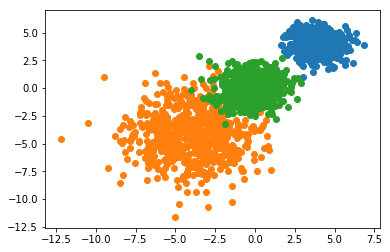

### 2. Learning by GMM:

4828.636929473993
4828.636929473993
4828.636929473995
4828.63692947399
4828.636929473993
mean plug-in parameters: 
 {'est_ratio': array([4.99875031e-05, 3.37105401e-01, 4.99875031e-05, 3.34649827e-01,
       3.28144798e-01]), 'est_mean': array([[ 0.        ,  0.        ],
       [-0.01278867,  0.03140593],
       [ 0.        ,  0.        ],
       [-3.79421916, -4.06399241],
       [ 3.99404328,  3.97402964]]), 'est_precision': array([[1.        , 1.        ],
       [0.96209902, 1.02699413],
       [1.        , 1.        ],
       [0.24521888, 0.21872153],
       [1.47240448, 1.72658006]])}


### 3.. Learning by HSMM:

1285.31183968373
1285.311839693077
1285.3118394664327
1285.311839772314
1285.3118397289031
mean plug-in parameters: 
 {'est_ratio': array([3.36763259e-01, 4.99875031e-05, 3.27977645e-01, 4.17751984e-02,
       2.93433910e-01]), 'est_mean': array([[ 2.24807024e-03,  2.95564247e-02],
       [-2.36162720e-16, -1.72318509e-16],
       [ 3.99786626e+00,  3.99067903e+00],
       [-2.24269585e+00, -1.80320977e+00],
       [-3.91400128e+00, -4.33216488e+00]]), 'est_precision': array([[ 7.50582366,  7.6624714 ],
       [ 1.        ,  1.        ],
       [11.46686437, 13.07569281],
       [ 3.07871589,  2.74484918],
       [ 2.07824088,  2.06286015]])}


### 4. Correct number of labeling of GMM:

+ 1961/2000

### 5. Correct number of labeling of HSMM:

+ 1951/2000

### 6. Generalization error of GMM:

+ 0.006573928871466023

### 7. Generalization error of HSMM:

+ 0.044388994540976

### 8. Data distribution labeled by GMM:

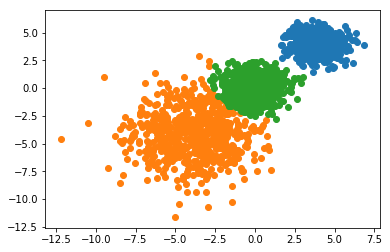

### 9. Data distribution labeled by HSMM:

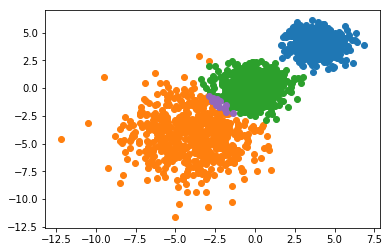

In [19]:
learning_and_labeling()

## 2. Cluster distribution is Hyperbolic secant distribution

In [20]:
true_logpdf = lambda x, param: logpdf_mixture_dist(x, param, logpdf_hypsecant)

In [21]:
np.random.seed(data_seed)
train_x = np.zeros((n, M))
for i in range(n):
    for j in range(M):
        train_x[i, j] = random_hsm(n = 1, loc=true_b[true_train_label_arg[i],j], scale=true_s[true_train_label_arg[i],j])

noise_data_num = math.ceil(n*true_delta)
if noise_data_num > 0:
    train_x[-noise_data_num:,:] = np.random.uniform(low=-30, high=30, size = noise_data_num*M).reshape(noise_data_num,M)
    
np.random.seed(test_seed)
test_x = np.zeros((test_data_num, M))
for i in range(test_data_num):
    for j in range(M):
        test_x[i, j] = random_hsm(n = 1, loc=true_b[true_test_label_arg[i],j], scale=true_s[true_test_label_arg[i],j])

noise_data_num = math.ceil(test_data_num*true_delta)
if noise_data_num > 0:
    test_x[-noise_data_num:,:] = np.random.uniform(low=-30, high=30, size = noise_data_num*M).reshape(noise_data_num,M)

### 1. Data distribution:

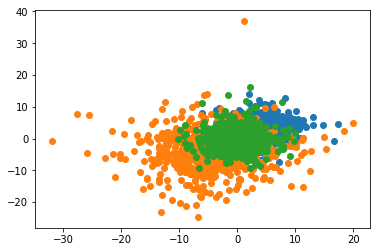

### 2. Learning by GMM:

8357.452329237753
8365.813865162672
8365.790917869159
8365.80386268467
8365.821895237626
mean plug-in parameters: 
 {'est_ratio': array([6.14447705e-02, 3.10393123e-01, 3.32310983e-01, 2.95801137e-01,
       4.99875031e-05]), 'est_mean': array([[-5.947901  , -5.13964313],
       [-0.36399488, -0.62513502],
       [ 3.92837391,  3.98627013],
       [-2.87742505, -2.65959596],
       [ 0.        ,  0.        ]]), 'est_precision': array([[0.14804271, 0.01403048],
       [0.15853561, 0.13128133],
       [0.18080598, 0.17551468],
       [0.01842777, 0.03081591],
       [1.        , 1.        ]])}


### 3.. Learning by HSMM:

4620.183914048865
4605.631033295891
4620.488833217039
4621.456828493672
4620.161173863455
mean plug-in parameters: 
 {'est_ratio': array([4.99875031e-05, 3.20154063e-01, 4.99875031e-05, 2.62158236e-01,
       4.17587726e-01]), 'est_mean': array([[ 5.09206632e-17, -7.59402091e-17],
       [ 3.99850810e+00,  4.11201302e+00],
       [ 5.09206632e-17, -7.59402091e-17],
       [-5.05042376e+00, -4.44809180e+00],
       [-2.77778908e-03, -2.97087068e-01]]), 'est_precision': array([[1.        , 1.        ],
       [1.40433276, 1.60446922],
       [1.        , 1.        ],
       [0.25315211, 0.24678166],
       [0.75209844, 0.87365742]])}


### 4. Correct number of labeling of GMM:

+ 1502/2000

### 5. Correct number of labeling of HSMM:

+ 1547/2000

### 6. Generalization error of GMM:

+ 0.020846339695114197

### 7. Generalization error of HSMM:

+ 0.001126303949976083

### 8. Data distribution labeled by GMM:

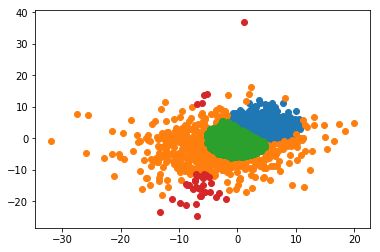

### 9. Data distribution labeled by HSMM:

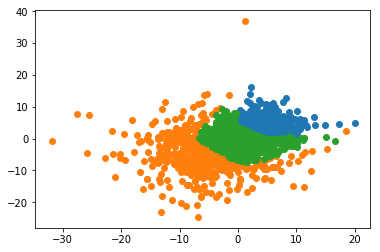

In [22]:
learning_and_labeling()

## 3. Cluster distribution is Laplace distribution

In [23]:
logpdf_laplace = lambda x, mean, precision: laplace.logpdf(test_x, loc=mean, scale=1/precision).sum(axis=1)
true_logpdf = lambda x, param: logpdf_mixture_dist(x, param, logpdf_laplace)

In [24]:
np.random.seed(data_seed)
train_x = np.zeros((n, M))
for i in range(n):
    for j in range(M):
        train_x[i, j] = laplace.rvs(loc=true_b[true_train_label_arg[i],j], scale=1/true_s[true_train_label_arg[i],j], size=1)

noise_data_num = math.ceil(n*true_delta)
if noise_data_num > 0:
    train_x[-noise_data_num:,:] = np.random.uniform(low=-30, high=30, size = noise_data_num*M).reshape(noise_data_num,M)
    
np.random.seed(test_seed)
test_x = np.zeros((test_data_num, M))
for i in range(test_data_num):
    for j in range(M):
        test_x[i, j] = laplace.rvs(loc=true_b[true_test_label_arg[i],j], scale=1/true_s[true_test_label_arg[i],j], size=1)

noise_data_num = math.ceil(test_data_num*true_delta)
if noise_data_num > 0:
    test_x[-noise_data_num:,:] = np.random.uniform(low=-30, high=30, size = noise_data_num*M).reshape(noise_data_num,M)

### 1. Data distribution:

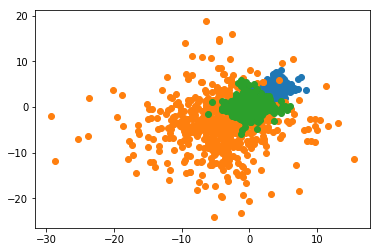

### 2. Learning by GMM:

6327.463581070117
6327.463580610093
6327.463580018208
6327.463581035676
6327.463580419613
mean plug-in parameters: 
 {'est_ratio': array([0.20054344, 0.26804392, 0.25918599, 0.12792759, 0.14429907]), 'est_mean': array([[-3.63239764, -3.21011213],
       [ 3.99773473,  4.06502106],
       [-0.0646833 , -0.02403582],
       [ 2.36105259,  2.38567589],
       [-4.95531609, -4.32710102]]), 'est_precision': array([[0.12656764, 0.0882446 ],
       [2.30269909, 2.06295523],
       [1.20603789, 1.09833298],
       [0.20370526, 0.15024101],
       [0.01995398, 0.0198578 ]])}


### 3.. Learning by HSMM:

2590.412745995054
2602.1511353744836
2590.4127459950514
2602.162315376044
2601.215886860379
mean plug-in parameters: 
 {'est_ratio': array([3.41676614e-01, 3.27167035e-01, 4.99875031e-05, 4.99875031e-05,
       3.31056376e-01]), 'est_mean': array([[-1.82972403e-02,  4.59547108e-02],
       [ 3.96307149e+00,  4.03651881e+00],
       [-1.96960919e-17, -4.73955709e-17],
       [-1.96960919e-17, -4.73955709e-17],
       [-4.03271970e+00, -3.66977518e+00]]), 'est_precision': array([[ 5.54079082,  5.69633002],
       [12.29644233, 10.72413226],
       [ 1.        ,  1.        ],
       [ 1.        ,  1.        ],
       [ 0.38510878,  0.34098642]])}


### 4. Correct number of labeling of GMM:

+ 1500/2000

### 5. Correct number of labeling of HSMM:

+ 1884/2000

### 6. Generalization error of GMM:

+ 0.04984496635775114

### 7. Generalization error of HSMM:

+ 0.01842255096396623

### 8. Data distribution labeled by GMM:

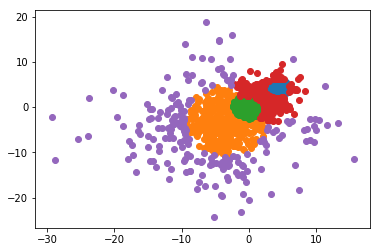

### 9. Data distribution labeled by HSMM:

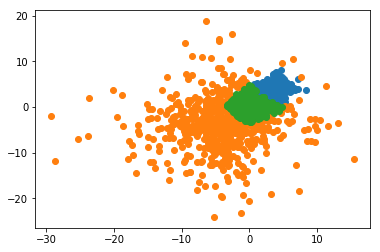

In [25]:
learning_and_labeling()

## 4. Cluster distribution is Gumbel distribution

In [26]:
logpdf_gumbel = lambda x, mean, precision: gumbel_r.logpdf(test_x, loc=mean, scale=1/precision).sum(axis=1)
true_logpdf = lambda x, param: logpdf_mixture_dist(x, param, logpdf_gumbel)

In [27]:
np.random.seed(data_seed)
train_x = np.zeros((n, M))
for i in range(n):
    for j in range(M):
        train_x[i, j] = gumbel_r.rvs(loc=true_b[true_train_label_arg[i],j], scale=1/true_s[true_train_label_arg[i],j], size=1)

noise_data_num = math.ceil(n*true_delta)
if noise_data_num > 0:
    train_x[-noise_data_num:,:] = np.random.uniform(low=-30, high=30, size = noise_data_num*M).reshape(noise_data_num,M)
    
np.random.seed(test_seed)
test_x = np.zeros((test_data_num, M))
for i in range(test_data_num):
    for j in range(M):
        test_x[i, j] = gumbel_r.rvs(loc=true_b[true_test_label_arg[i],j], scale=1/true_s[true_test_label_arg[i],j], size=1)

noise_data_num = math.ceil(test_data_num*true_delta)
if noise_data_num > 0:
    test_x[-noise_data_num:,:] = np.random.uniform(low=-30, high=30, size = noise_data_num*M).reshape(noise_data_num,M)

### 1. Data distribution:

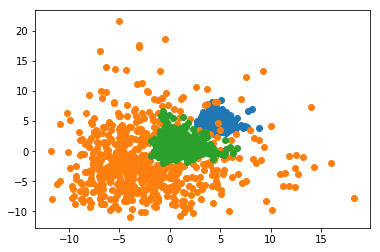

### 2. Learning by GMM:

5939.955518077313
5950.31964651519
5955.173841558999
5939.9555181435535
5979.263655891506
mean plug-in parameters: 
 {'est_ratio': array([0.30857324, 0.22599167, 0.1033205 , 0.21757856, 0.14453603]), 'est_mean': array([[ 4.25210676,  4.3305932 ],
       [ 0.32953874,  1.2266288 ],
       [ 1.54352071,  0.2718517 ],
       [-0.00627249,  0.51891223],
       [-3.99103721, -4.02510557]]), 'est_precision': array([[2.04466123, 1.75317887],
       [0.04066688, 0.03786509],
       [0.62249815, 1.24684114],
       [2.0232215 , 0.82612133],
       [0.11718286, 0.11156006]])}


### 3.. Learning by HSMM:

2313.547121131347
2313.54712127159
2320.5936929061563
2313.546205711199
2313.4117306435073
mean plug-in parameters: 
 {'est_ratio': array([0.34876589, 0.09589211, 0.33040528, 0.10741487, 0.11752185]), 'est_mean': array([[ 0.25971365,  0.38283134],
       [-2.63645026, -5.67512501],
       [ 4.21347322,  4.28731147],
       [-5.28265506, -0.60274276],
       [ 1.92004392,  0.89122736]]), 'est_precision': array([[ 6.28144969,  5.27768336],
       [ 0.63082001,  1.74946538],
       [13.24371415, 10.62353972],
       [ 1.6655138 ,  0.40335626],
       [ 0.4457973 ,  0.40013786]])}


### 4. Correct number of labeling of GMM:

+ 1434/2000

### 5. Correct number of labeling of HSMM:

+ 1540/2000

### 6. Generalization error of GMM:

+ 0.06544931733653642

### 7. Generalization error of HSMM:

+ 0.06670210475221117

### 8. Data distribution labeled by GMM:

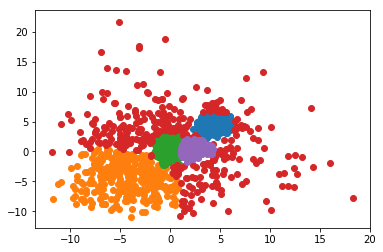

### 9. Data distribution labeled by HSMM:

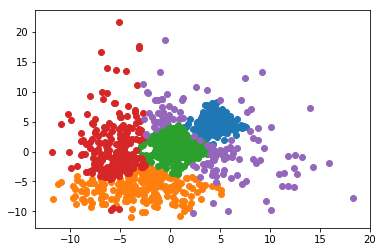

In [28]:
learning_and_labeling()

## 5. Cluster distribution is student distribution

In [29]:
logpdf_t = lambda x, mean, precision: t.logpdf(test_x, df=1.5, loc=mean, scale=1/precision).sum(axis=1)
true_logpdf = lambda x, param: logpdf_mixture_dist(x, param, logpdf_t)

In [30]:
np.random.seed(data_seed)
train_x = np.zeros((n, M))
for i in range(n):
    for j in range(M):
        train_x[i, j] = t.rvs(df = 1.5, loc=true_b[true_train_label_arg[i],j], scale=1/true_s[true_train_label_arg[i],j], size=1)

noise_data_num = math.ceil(n*true_delta)
if noise_data_num > 0:
    train_x[-noise_data_num:,:] = np.random.uniform(low=-30, high=30, size = noise_data_num*M).reshape(noise_data_num,M)
    
np.random.seed(test_seed)
test_x = np.zeros((test_data_num, M))
for i in range(test_data_num):
    for j in range(M):
        test_x[i, j] = t.rvs(df = 1.5, loc=true_b[true_test_label_arg[i],j], scale=1/true_s[true_test_label_arg[i],j], size=1)

noise_data_num = math.ceil(test_data_num*true_delta)
if noise_data_num > 0:
    test_x[-noise_data_num:,:] = np.random.uniform(low=-30, high=30, size = noise_data_num*M).reshape(noise_data_num,M)

### 1. Data distribution:

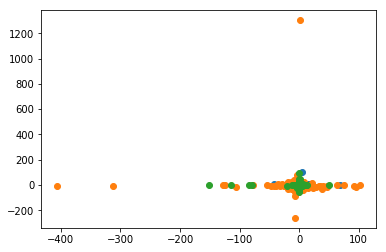

### 2. Learning by GMM:

8109.498108157183
8109.498108157188
8106.937363824269
8106.9373638242705
8109.498108157189
mean plug-in parameters: 
 {'est_ratio': array([0.26213664, 0.39835255, 0.01324557, 0.19534373, 0.1309215 ]), 'est_mean': array([[ 4.09884744e+00,  3.97274281e+00],
       [-1.16442313e+00, -1.49733227e+00],
       [-4.12521208e+01,  4.32145854e+01],
       [-1.68169569e-02, -2.39437557e-03],
       [-3.22503806e+00, -4.47877674e+00]]), 'est_precision': array([[1.21385644e+00, 1.18253295e+00],
       [5.10093440e-02, 4.46851022e-02],
       [8.40878676e-05, 1.73705973e-05],
       [1.27511786e+00, 1.17596280e+00],
       [4.75527672e-03, 5.35410748e-03]])}


### 3.. Learning by HSMM:

4297.731372332055
4250.884151895446
4250.884151895434
4297.731372328677
4250.884151895442
mean plug-in parameters: 
 {'est_ratio': array([0.29291117, 0.40065974, 0.00877151, 0.27079978, 0.02685779]), 'est_mean': array([[ 4.03924878e+00,  3.94985342e+00],
       [-2.31538589e+00, -2.79441718e+00],
       [-1.24352316e+00,  7.09713222e-01],
       [-2.47490341e-03, -2.78911343e-02],
       [-1.16686087e+01, -3.07746670e+00]]), 'est_precision': array([[8.11675006e+00, 7.71304213e+00],
       [2.22505204e-01, 1.79811643e-01],
       [5.86992584e-01, 4.53171180e-04],
       [5.37389069e+00, 5.02492412e+00],
       [1.98280708e-03, 2.62937960e-01]])}


### 4. Correct number of labeling of GMM:

+ 1391/2000

### 5. Correct number of labeling of HSMM:

+ 1671/2000

### 6. Generalization error of GMM:

+ 0.13641616131508158

### 7. Generalization error of HSMM:

+ 0.060753055800328276

### 8. Data distribution labeled by GMM:

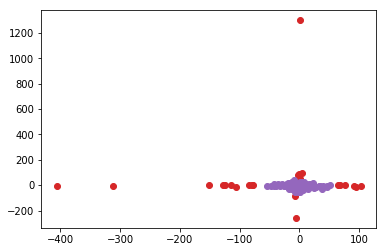

### 9. Data distribution labeled by HSMM:

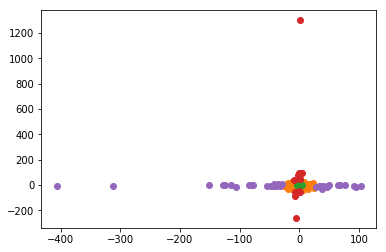

In [31]:
learning_and_labeling()

## 6. Cluster distribution is Cauchy distribution

In [32]:
logpdf_cauchy = lambda x, mean, precision: cauchy.logpdf(test_x, loc=mean, scale=1/precision).sum(axis=1)
true_logpdf = lambda x, param: logpdf_mixture_dist(x, param, logpdf_cauchy)

In [33]:
np.random.seed(data_seed)
train_x = np.zeros((n, M))
for i in range(n):
    for j in range(M):
        train_x[i, j] = cauchy.rvs(loc=true_b[true_train_label_arg[i],j], scale=1/true_s[true_train_label_arg[i],j], size=1)

noise_data_num = math.ceil(n*true_delta)
if noise_data_num > 0:
    train_x[-noise_data_num:,:] = np.random.uniform(low=-30, high=30, size = noise_data_num*M).reshape(noise_data_num,M)
    
np.random.seed(test_seed)
test_x = np.zeros((test_data_num, M))
for i in range(test_data_num):
    for j in range(M):
        test_x[i, j] = cauchy.rvs(loc=true_b[true_test_label_arg[i],j], scale=1/true_s[true_test_label_arg[i],j], size=1)

noise_data_num = math.ceil(test_data_num*true_delta)
if noise_data_num > 0:
    test_x[-noise_data_num:,:] = np.random.uniform(low=-30, high=30, size = noise_data_num*M).reshape(noise_data_num,M)

### 1. Data distribution:

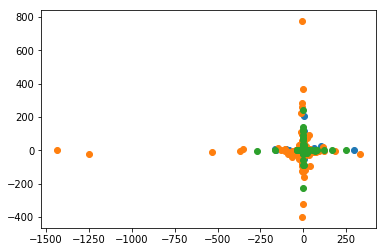

### 2. Learning by GMM:

9605.78390954186
9849.687843034293
9849.687843034295
9424.923383558753
9849.687843034299
mean plug-in parameters: 
 {'est_ratio': array([0.46213848, 0.22140532, 0.05041158, 0.06672472, 0.1993199 ]), 'est_mean': array([[-1.46774725e+00, -8.74113063e-01],
       [ 3.97558016e+00,  3.97346069e+00],
       [-3.66367301e+01, -3.13377426e+00],
       [-1.67323135e+00,  1.13213068e+01],
       [-6.71772475e-02,  3.04186762e-02]]), 'est_precision': array([[2.23930168e-02, 2.50424793e-02],
       [1.43381875e+00, 1.23872262e+00],
       [2.17609653e-05, 1.09708071e-02],
       [1.47894327e-02, 7.99957608e-05],
       [9.42984415e-01, 7.35718263e-01]])}


### 3.. Learning by HSMM:

5526.8571214689855
5526.857121469
5526.857121468979
5526.857121468981
5526.857121468982
mean plug-in parameters: 
 {'est_ratio': array([0.04681035, 0.25600246, 0.21500307, 0.41922586, 0.06295825]), 'est_mean': array([[-7.88626824, -2.04347033],
       [ 3.9804328 ,  4.00676949],
       [-0.05781431,  0.06250384],
       [-2.07244674, -1.53502777],
       [-1.45073323,  5.82545652]]), 'est_precision': array([[5.32073998e-04, 1.22743348e-01],
       [8.26624895e+00, 7.03939671e+00],
       [6.34223885e+00, 4.53200957e+00],
       [1.88197446e-01, 2.08021568e-01],
       [2.01979748e-01, 1.30732047e-03]])}


### 4. Correct number of labeling of GMM:

+ 1324/2000

### 5. Correct number of labeling of HSMM:

+ 1425/2000

### 6. Generalization error of GMM:

+ 1.695281928715349

### 7. Generalization error of HSMM:

+ 0.19058297869984725

### 8. Data distribution labeled by GMM:

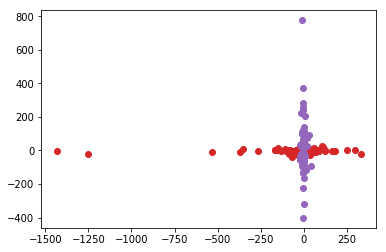

### 9. Data distribution labeled by HSMM:

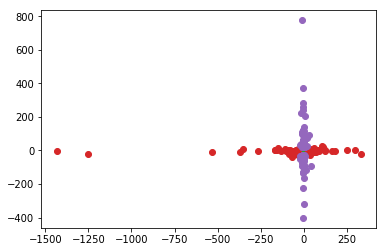

In [34]:
learning_and_labeling()

## 7. Cluster distribution is Gamma distribution
+ Remark: Actually support of gamma distribution is not whole real line, but scipy can generate data with loc on real value.

In [35]:
logpdf_gamma = lambda x, mean, precision: gamma.logpdf(test_x, a=1, loc=mean, scale=1/precision).sum(axis=1)
true_logpdf = lambda x, param: logpdf_mixture_dist(x, param, logpdf_gamma)

In [36]:
np.random.seed(data_seed)
train_x = np.zeros((n, M))
for i in range(n):
    for j in range(M):
        train_x[i, j] = gamma.rvs(a = 1, loc=true_b[true_train_label_arg[i],j], scale=1/true_s[true_train_label_arg[i],j], size=1)

noise_data_num = math.ceil(n*true_delta)
if noise_data_num > 0:
    train_x[-noise_data_num:,:] = np.random.uniform(low=-30, high=30, size = noise_data_num*M).reshape(noise_data_num,M)
    
np.random.seed(test_seed)
test_x = np.zeros((test_data_num, M))
for i in range(test_data_num):
    for j in range(M):
        test_x[i, j] = gamma.rvs(a = 1, loc=true_b[true_test_label_arg[i],j], scale=1/true_s[true_test_label_arg[i],j], size=1)

noise_data_num = math.ceil(test_data_num*true_delta)
if noise_data_num > 0:
    test_x[-noise_data_num:,:] = np.random.uniform(low=-30, high=30, size = noise_data_num*M).reshape(noise_data_num,M)

### 1. Data distribution:

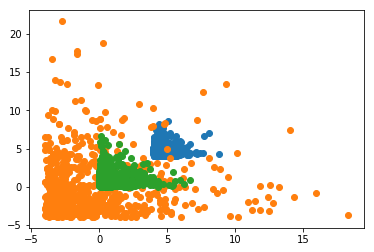

### 2. Learning by GMM:

4519.656491515725
4519.656491515729
4519.656491515725
4493.24340451014
4519.6564915157505
mean plug-in parameters: 
 {'est_ratio': array([0.11345652, 0.19212429, 0.13827159, 0.26607697, 0.29007063]), 'est_mean': array([[ 1.46479183,  0.60562289],
       [ 0.42732281,  0.89877735],
       [-2.10949137, -2.13746622],
       [ 1.87800902,  2.47108576],
       [ 4.51797926,  4.57191337]]), 'est_precision': array([[ 1.46292473,  4.03764596],
       [10.12911037,  1.87496813],
       [ 0.55836426,  0.55570295],
       [ 0.07159696,  0.06536537],
       [ 5.24206822,  4.2069123 ]])}


### 3.. Learning by HSMM:

961.656247701665
961.656247701711
961.6562477017287
961.6562477017806
961.6562477018092
mean plug-in parameters: 
 {'est_ratio': array([0.33538075, 0.1526297 , 0.09396976, 0.31498462, 0.10303516]), 'est_mean': array([[ 0.64288285,  0.73261993],
       [ 2.85848901,  1.91567842],
       [-2.90455571,  0.75795208],
       [ 4.47529065,  4.52670655],
       [-1.49328423, -2.90290613]]), 'est_precision': array([[15.08626789, 11.34295425],
       [ 0.74491837,  0.62047073],
       [ 9.38093187,  0.68141642],
       [27.88655413, 22.06322954],
       [ 2.28865233,  8.45865123]])}


### 4. Correct number of labeling of GMM:

+ 1321/2000

### 5. Correct number of labeling of HSMM:

+ 1496/2000

### 6. Generalization error of GMM:

+ 0.434264175878483

### 7. Generalization error of HSMM:

+ 0.4299027917151727

### 8. Data distribution labeled by GMM:

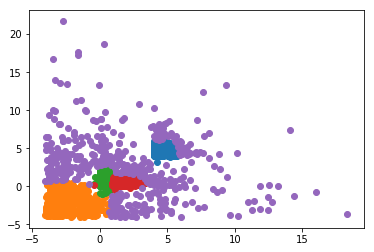

### 9. Data distribution labeled by HSMM:

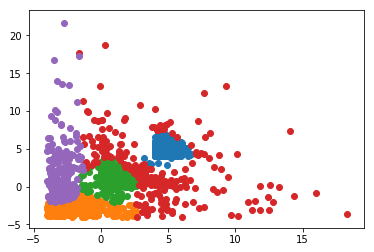

In [37]:
learning_and_labeling()

## 8. Cluster distribution is Skew Normal distribution

In [45]:
logpdf_skewnormal = lambda x, mean, precision: skewnorm.logpdf(test_x, a=2, loc=mean, scale=1/precision).sum(axis=1)
true_logpdf = lambda x, param: logpdf_mixture_dist(x, param, logpdf_skewnormal)

In [46]:
np.random.seed(data_seed)
train_x = np.zeros((n, M))
for i in range(n):
    for j in range(M):
        train_x[i, j] = skewnorm.rvs(a = 2, loc=true_b[true_train_label_arg[i],j], scale=1/true_s[true_train_label_arg[i],j], size=1)

noise_data_num = math.ceil(n*true_delta)
if noise_data_num > 0:
    train_x[-noise_data_num:,:] = np.random.uniform(low=-30, high=30, size = noise_data_num*M).reshape(noise_data_num,M)
    
np.random.seed(test_seed)
test_x = np.zeros((test_data_num, M))
for i in range(test_data_num):
    for j in range(M):
        test_x[i, j] = skewnorm.rvs(a = 2, loc=true_b[true_test_label_arg[i],j], scale=1/true_s[true_test_label_arg[i],j], size=1)

noise_data_num = math.ceil(test_data_num*true_delta)
if noise_data_num > 0:
    test_x[-noise_data_num:,:] = np.random.uniform(low=-30, high=30, size = noise_data_num*M).reshape(noise_data_num,M)

### 1. Data distribution:

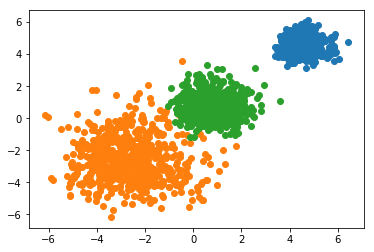

### 2. Learning by GMM:

3220.0170116761774
3220.0161905092427
3212.3160662792343
3207.8981591473257
3212.3058526456703
mean plug-in parameters: 
 {'est_ratio': array([0.02270847, 0.33519793, 0.18523618, 0.1283947 , 0.32846273]), 'est_mean': array([[ 0.90503674,  1.85278811],
       [ 0.68731943,  0.58995572],
       [-2.91225833, -1.98201453],
       [-2.40827656, -3.54512276],
       [ 4.49134123,  4.49946193]]), 'est_precision': array([[0.93645726, 1.44374183],
       [2.02007702, 2.10996183],
       [0.81693973, 0.55647397],
       [0.45469439, 1.49043611],
       [4.45453997, 4.33018153]])}


### 3.. Learning by HSMM:

-274.0286779781759
-274.02867797814133
-274.02867797813633
-274.0286779781377
-274.0286779780945
mean plug-in parameters: 
 {'est_ratio': array([3.08328147e-01, 3.62818896e-01, 4.99875031e-05, 3.28752982e-01,
       4.99875031e-05]), 'est_mean': array([[-2.77400115e+00, -2.75769969e+00],
       [ 6.56892425e-01,  6.22254173e-01],
       [-5.81231159e-17, -4.07278051e-17],
       [ 4.46355199e+00,  4.47940879e+00],
       [-5.81231159e-17, -4.07278051e-17]]), 'est_precision': array([[ 4.81458889,  4.36678992],
       [13.94659733, 13.16389743],
       [ 1.        ,  1.        ],
       [30.02846943, 28.60684406],
       [ 1.        ,  1.        ]])}


### 4. Correct number of labeling of GMM:

+ 1679/2000

### 5. Correct number of labeling of HSMM:

+ 1974/2000

### 6. Generalization error of GMM:

+ 0.02270293499911528

### 7. Generalization error of HSMM:

+ 0.06776521327759971

### 8. Data distribution labeled by GMM:

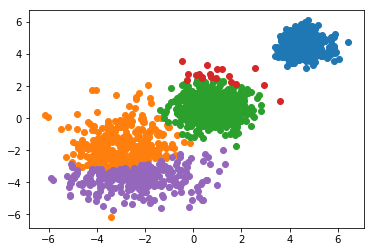

### 9. Data distribution labeled by HSMM:

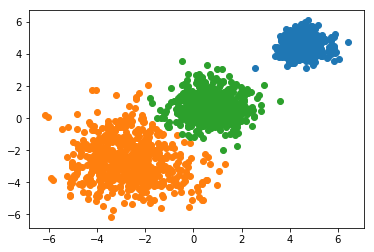

In [47]:
learning_and_labeling()

## 9. Cluster distribution is Parato distribution
+ Parato distribution has inifite variance if $shape \leq 2$.

In [41]:
logpdf_pareto = lambda x, mean, precision: pareto.logpdf(test_x, b=1.5, loc=mean, scale=1/precision).sum(axis=1)
true_logpdf = lambda x, param: logpdf_mixture_dist(x, param, logpdf_pareto)

In [42]:
np.random.seed(data_seed)
train_x = np.zeros((n, M))
for i in range(n):
    for j in range(M):
        train_x[i, j] = pareto.rvs(b = 1.5, loc=true_b[true_train_label_arg[i],j], scale=1/true_s[true_train_label_arg[i],j], size=1)

noise_data_num = math.ceil(n*true_delta)
if noise_data_num > 0:
    train_x[-noise_data_num:,:] = np.random.uniform(low=-30, high=30, size = noise_data_num*M).reshape(noise_data_num,M)
    
np.random.seed(test_seed)
test_x = np.zeros((test_data_num, M))
for i in range(test_data_num):
    for j in range(M):
        test_x[i, j] = pareto.rvs(b = 1.5, loc=true_b[true_test_label_arg[i],j], scale=1/true_s[true_test_label_arg[i],j], size=1)

noise_data_num = math.ceil(test_data_num*true_delta)
if noise_data_num > 0:
    test_x[-noise_data_num:,:] = np.random.uniform(low=-30, high=30, size = noise_data_num*M).reshape(noise_data_num,M)

### 1. Data distribution:

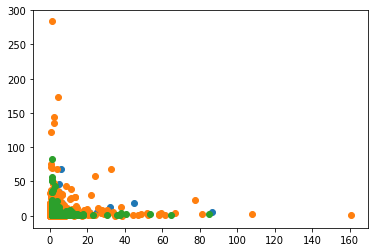

### 2. Learning by GMM:

5540.506796809941
5540.506796809943
6126.873673837155
5540.506796809916
5550.261372931036
mean plug-in parameters: 
 {'est_ratio': array([0.30199585, 0.08310002, 0.21899721, 0.03746029, 0.35844662]), 'est_mean': array([[ 5.57565656,  4.30253864],
       [ 2.81862976, 14.60924766],
       [ 5.03618567,  5.06724492],
       [30.47668904, 28.85194038],
       [ 1.52331131,  1.60727176]]), 'est_precision': array([[7.02793337e-02, 1.48987038e-01],
       [2.68793916e-01, 1.16992513e-02],
       [8.42058077e+00, 7.18085855e+00],
       [1.28855115e-03, 4.73907196e-04],
       [1.82756663e+00, 1.46604712e+00]])}


### 3.. Learning by HSMM:

1930.0932836816621
1930.0932837009377
1889.7612569125527
1947.3107955120677
1889.7612569125802
mean plug-in parameters: 
 {'est_ratio': array([0.27107098, 0.03741754, 0.38936866, 0.2513367 , 0.05080612]), 'est_mean': array([[ 4.85215436,  5.05678222],
       [26.78423002,  2.59050568],
       [ 1.46761739,  1.56088029],
       [ 5.0204353 ,  5.0458356 ],
       [ 2.82934814, 25.99340464]]), 'est_precision': array([[7.43576458e-01, 6.49649780e-01],
       [1.78397508e-02, 9.74320046e-01],
       [1.29636647e+01, 1.00381261e+01],
       [3.18074862e+01, 2.68540301e+01],
       [7.48457679e-01, 1.52629818e-02]])}


### 4. Correct number of labeling of GMM:

+ 1214/2000

### 5. Correct number of labeling of HSMM:

+ 1298/2000

### 6. Generalization error of GMM:

+ 1.1168918595333224

### 7. Generalization error of HSMM:

+ 0.6154247079743798

### 8. Data distribution labeled by GMM:

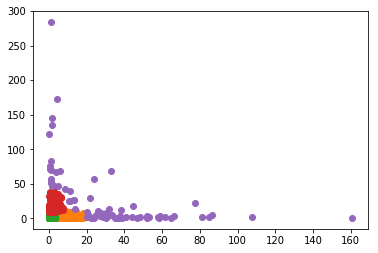

### 9. Data distribution labeled by HSMM:

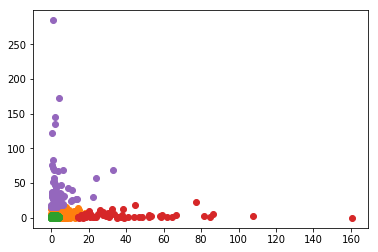

In [43]:
learning_and_labeling()